# California house price prediction

Made by: __Rakesh Nain__

## Introduction
Build a model of housing prices in California using the California census
data. This data has metrics such as the population, median income, median housing
price, and so on for each block group in California. Block groups are the smallest
geographical unit for which the US Census Bureau publishes sample data (a block
group typically has a population of 600 to 3,000 people). We will just call them “districts”
for short.

AIM:
Model should learn from this data and be able to predict the median housing
price in any district, given all the other metrics.

### Data Set
In this project we chose the California Housing Prices dataset from the StatLib repository
(see Figure 2-1). This dataset was based on data from the 1990 California census.
It is not exactly recent (you could still afford a nice house in the Bay Area at the
time), but it has many qualities for learning, so we will pretend it is recent data.

*Note: Data set is in the same [github repository](https://github.com/RakeshNain/California_house_price_prediction.git).

#### Importing required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from scipy import stats

#### Get the data

In [2]:
# reading the data into dataframe
housing = pd.read_csv("housing.csv")

### Exploratory data analysis

In [3]:
# checking 1st five rows of data
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Each row represents one district. There are 10 attributes longitude, latitude, housing_median_age, total_rooms, total_bed
rooms, population, households, median_income, median_house_value, and
ocean_proximity.

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20,640 instances in the dataset. Notice that the total_bed
rooms attribute has only 20,433 non-null values, meaning that 207 districts are missing
this feature. We will need to take care of this later.

All attributes are numerical, except the ocean_proximity field. Its type is object, so it
could hold any kind of Python object, but since you loaded this data from a CSV file
you know that it must be a text attribute. When you looked at the top five rows, you
probably noticed that the values in the ocean_proximity column were repetitive,
which means that it is probably a categorical attribute.

Lets find out what categories
exist and how many districts belong to each category by using the
value_counts() method

In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Let’s look at the other fields.

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


The count, mean, min, and max rows are self-explanatory.

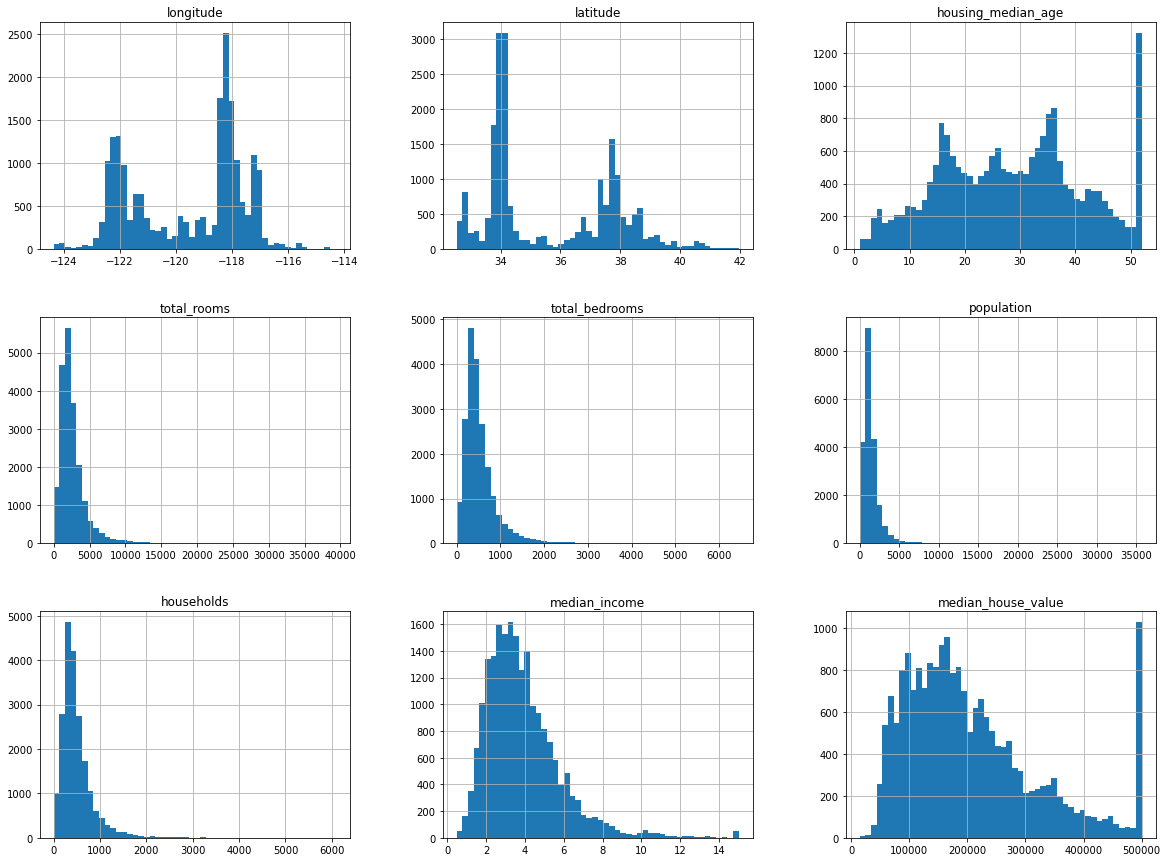

In [7]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

Notice a few things in these histograms:
1. First, the median income attribute does not look like it is expressed in US dollars (USD). After researching it came up the data has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000).


2. The housing median age and the median house value were also capped. The latter
may be a serious problem since it is your target attribute (your labels). My
Machine Learning algorithms may learn that prices never go beyond that limit.
We need to check with our business requirement, to see if this is a problem or not. If it tell that it need precise predictions
even beyond $500,000, then you have mainly two options:

    - Collect proper labels for the districts whose labels were capped.
    - Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond $500,000).


3. These attributes have very different scales. We might need feature scaling.


4. Finally, many histograms are tail heavy: they extend much farther to the right of
the median than to the left. This may make it a bit harder for some Machine
Learning algorithms to detect patterns. We will try transforming these attributes
later on to have more bell-shaped distributions.

#### Splitting test and train data

In [8]:
# train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)
# print(len(train_set), "train +", len(test_set), "test")

According to the researchm the median income is a very
important attribute to predict median housing prices. You may want to ensure that
the test set is representative of the various categories of incomes in the whole dataset.
Since the median income is a continuous numerical attribute, you first need to create
an income category attribute. Let’s look at the median income histogram more closely

<AxesSubplot:>

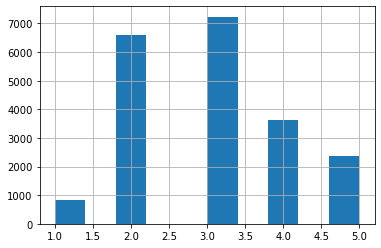

In [9]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

Clearly, most median income values are clustered around 1.5 to 6 (i.e., $15,000–$60,000), but some median incomes go far beyond 6. It is important to have
a sufficient number of instances in your dataset for each stratum, or else the estimate
of the stratum’s importance may be biased. This means that you should not have too
many strata, and each stratum should be large enough.

In [10]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Let’s see if this worked as expected. You can start by looking at the income category
proportions in the test set:

In [11]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [12]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

In [13]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

Now you should remove the income_cat attribute so the data is back to its original
state:

In [14]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

In [15]:
housing = strat_train_set.copy()

Since there is geographical information (latitude and longitude), it is a good idea to
create a scatterplot of all districts to visualize the data

Setting the alpha option to 0.1 makes it much easier to visualize the places
where there is a high density of data points

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

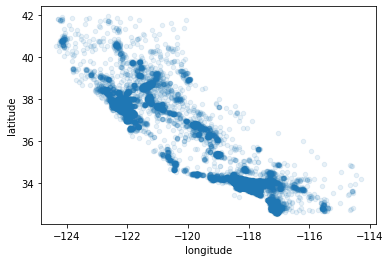

In [16]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Now that’s much better: you can clearly see the high-density areas, namely the Bay
Area and around Los Angeles and San Diego, plus a long line of fairly high density in
the Central Valley, in particular around Sacramento and Fresno.

Now let’s look at the housing prices. The radius of each circle represents
the district’s population (option s), and the color represents the price (option c). We
will use a predefined color map (option cmap) called jet, which ranges from blue
(low values) to red (high prices):

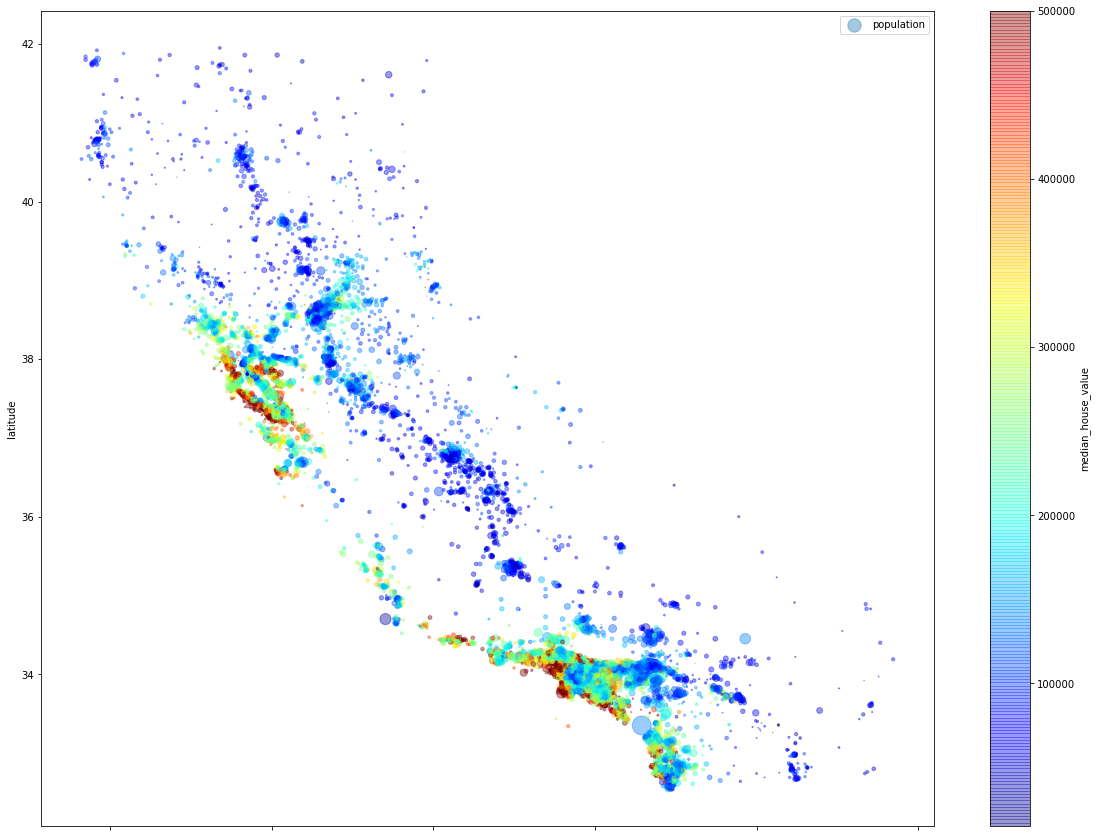

In [17]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population",
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, figsize=(20,15)
            )
plt.legend()

This image tells you that the housing prices are very much related to the location
(e.g., close to the ocean) and to the population density, as you probably knew already.
It will probably be useful to use a clustering algorithm to detect the main clusters, and
add new features that measure the proximity to the cluster centers. The ocean proximity
attribute may be useful as well, although in Northern California the housing
prices in coastal districts are not too high, so it is not a simple rule.

In [18]:
housing.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


Now let’s look at how much each attribute correlates with the median house value:

In [19]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

- the median house value tends to go up when the median income goes up.
- you can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north).

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

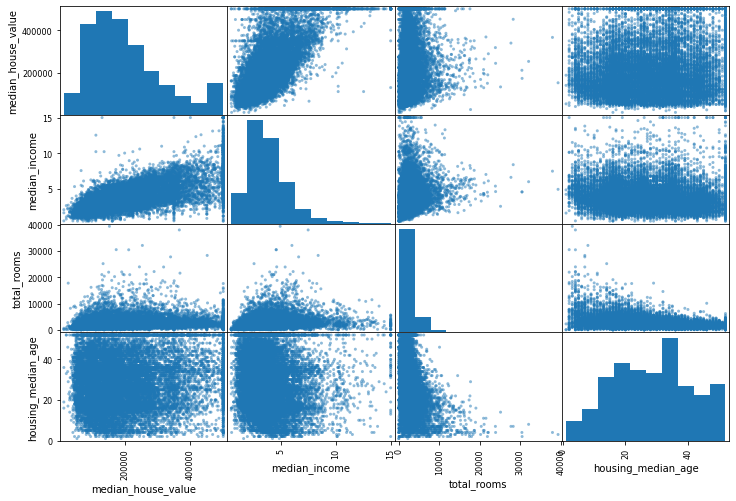

In [20]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

The most promising attribute to predict the median house value is the median
income, so let’s zoom in on their correlation scatterplot

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

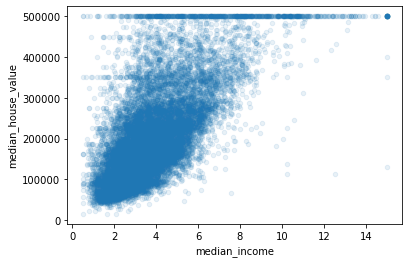

In [21]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

This plot reveals a few things. First, the correlation is indeed very strong; you can
clearly see the upward trend and the points are not too dispersed. Second, the price
cap that we noticed earlier is clearly visible as a horizontal line at 500,000. 
But thisplot reveals other less obvious straight lines: a horizontal line around 450,000,
another around 350,000,
perhaps one around 280,000, and a few more below that.
You may want to try removing the corresponding districts to prevent your algorithms
from learning to reproduce these data quirks.

The total number of rooms in a district is not very useful if we don’t know how many
households there are. What we really want is the number of rooms per household.
Similarly, the total number of bedrooms by itself is not very useful: I probably
want to compare it to the number of rooms. And the population per household also
seems like an interesting attribute combination to look at. Let’s create these new attributes:

In [22]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

And now let’s look at the correlation matrix again:

In [23]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Hey, not bad! The new bedrooms_per_room attribute is much more correlated with
the median house value than the total number of rooms or bedrooms. Apparently
houses with a lower bedroom/room ratio tend to be more expensive. The number of
rooms per household is also more informative than the total number of rooms in a
district—obviously the larger the houses, the more expensive they are.

#### Prepare the Data for Machine Learning Algorithms

First let’s revert to a clean training set (by copying strat_train_set once again),
and let’s separate the predictors and the labels since we don’t necessarily want to apply
the same transformations to the predictors and the target values.

In [24]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

Filling null values with the columns median.

In [25]:
# Since the median can only be computed on numerical attributes, 
# we need to create a copy of the data without the text attribute ocean_proximity
housing_num = housing.drop("ocean_proximity", axis=1)

# Handling Text and Categorical Attributes
housing_cat = housing[["ocean_proximity"]]

Most Machine Learning algorithms prefer to work with numbers anyway, so let’s convert
these categories from text to numbers. For this, we need one-hot encoding.

Although Scikit-Learn provides many useful transformers, we need to write
our own for tasks such as custom cleanup operations or combining specific
attributes. We want your transformer to work seamlessly with Scikit-Learn functionalities
(such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance),
all we need is to create a class and implement three methods: fit()
(returning self), transform(), and fit_transform().

In [26]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

One of the most important transformations we need to apply to our data is feature
scaling. With few exceptions, Machine Learning algorithms don’t perform well when
the input numerical attributes have very different scales. This is the case for the housing
data: the total number of rooms ranges from about 6 to 39,320, while the median
incomes only range from 0 to 15. Note that scaling the target values is generally not
required.

We will be doing standardization using StandardScaler()

As you can see, there are many data transformation steps that need to be executed in
the right order. Here is a small pipeline for the numerical attributes:

In [27]:
num_pipeline = Pipeline([
                        ('imputer', SimpleImputer(strategy="median")),
                        ('attribs_adder', CombinedAttributesAdder()),
                        ('std_scaler', StandardScaler()),
                        ])
housing_num_tr = num_pipeline.fit_transform(housing_num)

So far, we have handled the numerical columns.

It would be more convenient to have a single transformer able to handle all columns(numerical + categorical).

In [28]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
                                ("num", num_pipeline, num_attribs),
                                ("cat", OneHotEncoder(), cat_attribs),
                                ])
housing_prepared = full_pipeline.fit_transform(housing)

Let’s first train a Linear Regression model

In [29]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

Lets check its prediction accuracy on few sample data points.

In [30]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [31]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


It works, although the predictions are not exactly accurate (e.g., the first prediction is
off by close to 40%!). Let’s measure this regression model’s RMSE on the whole training
set

In [32]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

Okay, this is better than nothing but clearly not a great score: most districts’
median_housing_values range between 120,000 and 265,000, so a typical prediction
error of 68,628 is not very satisfying. This is a model underfitting.

Let’s train a DecisionTreeRegressor. This is a powerful model, capable of finding
complex nonlinear relationships in the data.

In [33]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Could this model really be absolutely perfect? Of course,
it is much more likely that the model has badly overfit the data.

We need something more robust for measuring the performance of Decision Tree. The following
code randomly splits the training set into 10 distinct subsets called folds, then it
trains and evaluates the Decision Tree model 10 times, picking a different fold for
evaluation every time and training on the other 9 folds. The result is an array containing
the 10 evaluation scores

In [34]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([69086.64557734, 65852.38745726, 70432.99501537, 69605.89132658,
       71742.88496082, 75152.94276488, 70048.19625679, 71448.18397964,
       74905.05244434, 68820.23208737])

In [35]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [69086.64557734 65852.38745726 70432.99501537 69605.89132658
 71742.88496082 75152.94276488 70048.19625679 71448.18397964
 74905.05244434 68820.23208737]
Mean: 70709.541187038
Standard deviation: 2654.9320919198


In [36]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798344


Now the Decision Tree doesn’t look as good as it did earlier. In fact, it seems to perform
worse than the Linear Regression model! Notice that cross-validation allows
you to get not only an estimate of the performance of your model, but also a measure
of how precise this estimate is (i.e., its standard deviation). The Decision Tree has a
score of approximately 70,709, generally ±2,654.

Let’s compute the same scores for the Linear Regression model just to be sure:

In [37]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798344


That’s right: the Decision Tree model is overfitting so badly that it performs worse
than the Linear Regression model.

Let’s try one last model now: the RandomForestRegressor.Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a model on top of many
other models is called Ensemble Learning, and it is often a great way to push ML algorithms
even further.

In [38]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
# forest_rmse

scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_reg_rmse_scores = np.sqrt(-scores)

In [39]:
display_scores(forest_reg_rmse_scores)

Scores: [49725.66587352 47878.30260206 49813.65586684 52195.62864409
 49317.62369882 53610.99431067 48744.10218655 47870.02657569
 52929.86668264 50512.01812458]
Mean: 50259.78845654591
Standard deviation: 1929.3193797472136


Wow, this is much better: Random Forests look very promising. However, note that
the score on the training set is still much lower than on the validation sets, meaning
that the model is still overfitting the training set. Possible solutions for overfitting are
to simplify the model, constrain it (i.e., regularize it), or get a lot more training data.

#### Fine-Tune Your Model

Using Grid Search to find best possible hyperparameters.

In [40]:
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

This param_grid tells Scikit-Learn to first evaluate all 3 × 4 = 12 combinations of
n_estimators and max_features hyperparameter values specified in the first dict
, then try all 2 × 3 = 6 combinations of hyperparameter values in the
second dict, but this time with the bootstrap hyperparameter set to False instead of
True (which is the default value for this hyperparameter).

All in all, the grid search will explore 12 + 6 = 18 combinations of RandomForestRe
gressor hyperparameter values, and it will train each model five times (since we are
using five-fold cross validation). In other words, all in all, there will be 18 × 5 = 90
rounds of training! It may take quite a long time, but when it is done you can get the
best combination of parameters like this:

In [41]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

### Evaluate Your System on the Test Set
After tweaking your models for a while, you eventually have a system that performs
sufficiently well. Now is the time to evaluate the final model on the test set. There is
nothing special about this process; just get the predictors and the labels from your
test set, run your full_pipeline to transform the data (call transform(), not
fit_transform(), you do not want to fit the test set!), and evaluate the final model
on the test set:

In [42]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48170.75793778907

In some cases, such a point estimate of the generalization error will not be quite
enough to convince you to launch: what if it is just 0.1% better than the model currently
in production? You might want to have an idea of how precise this estimate is.
For this, you can compute a 95% confidence interval for the generalization error using
scipy.stats.t.interval():

In [43]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([46154.21469684, 50106.21025701])